#### This models what occurs in the tumor tissue, from a starting point of macrophages that have localized to the tumor — the ME part of ADME

# Imports and useful functions

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from collections import namedtuple

plt.rcParams.update({'font.size': 8})
plt.rcParams['font.sans-serif'] = ['Arial']

def make_plot_look_good(axes):
    axes.axhline(0, color=[0.2, 0.2, 0.2], linewidth=1)
    axes.axvline(0, color=[0.2, 0.2, 0.2], linewidth=1)
    axes.grid(True, which='both', linestyle='--', linewidth=0.5)
    for spine in axes.spines.values():
        spine.set_visible(False)

def set_axes_labels(axes, x_label, y_label, title, legend_title=None, fontsize=7):
    axes.set_xlabel(x_label, fontsize=fontsize)
    axes.set_ylabel(y_label, fontsize=fontsize)
    axes.set_title(title, fontsize=fontsize)
    if legend_title is not None:
        axes.legend(title=legend_title,bbox_to_anchor=(1,1))
    make_plot_look_good(axes)

def simulate_binding_recycling_and_degradation(t, rate_constants, Species, therapy):
    # concatenate state variable initial values into a list
    x_initial_value = np.array( [ iv.initial_value for iv in Species.values() ] )

    assert therapy in ['CAR', 'Ab'], 'Unrecognized therapy'
    if therapy == 'CAR':
        dydt = dydt_CAR
    else:
        dydt = dydt_Ab

    # call solve_ivp. this problem is stiff, so it is necessary to use an algorithm that can handle stiff systems.
    solution = solve_ivp(dydt, [t[0], t[-1]], x_initial_value,
                         args=(rate_constants, Species),
                         t_eval=t,
                         atol=1e-40,
                         dense_output=True,
                         method='Radau')

    # create a dictionary with keys equal to state variable names and values equal to simulation
    # this is handy for plotting or just accessing the state variable values
    simulation_results_dictionary = dict( (key, value) for key, value in zip(Species.keys(), solution.y) )
    # add time axis to results
    simulation_results_dictionary['t'] = t

    return simulation_results_dictionary, solution


# Simulation information: species and rate constants

In [62]:
Species = namedtuple('Species', ['description', 'initial_value', 'units'])

# wrapper for metadata, to make looping easier later
def state_variable_metadata_CAR(macrophage_conc):
    return {
        'IL-6': Species(description="Soluble IL-6", initial_value=6.4e-23, units='M'),
        'macrophages': Species(description="Concentration of macrophage cells", initial_value=macrophage_conc, units='M'),

        # Surface species
        'Rs': Species(description="Surface IL-6R", initial_value=10000*macrophage_conc, units='M'),
        'Cs': Species(description="Surface IL-6R/IL-6 complex", initial_value=0, units='M'),
        'CARs': Species(description="Surface CAR", initial_value=100000*macrophage_conc, units='M'),
        # 'CARs': Species(description="Surface CAR", initial_value=0, units='M'),
        'CARCs': Species(description="Surface CAR/IL-6 complex", initial_value=0, units='M'),

        # Endocytosed species
        'Re': Species(description="Endocytosed IL-6R", initial_value=0, units='M'),
        'Ce': Species(description="Endocytosed IL-6R/IL-6 complex", initial_value=0, units='M'),
        'CARe': Species(description="Endocytosed CAR", initial_value=0, units='M'),

        # Phagocytosed species
        'CARp': Species(description="Phagocytosed CAR/IL-6 complex", initial_value=0, units='M')
    }

def state_variable_metadata_Ab(macrophage_conc):   # FREE-FLOATING Abs (Siltuximab)
    return {
        'IL-6': Species(description="Soluble IL-6", initial_value=6.4e-13, units='M'),
        'macrophages': Species(description="Concentration of macrophage cells", initial_value=macrophage_conc, units='M'),

        # Surface species
        'Rs': Species(description="Surface IL-6R", initial_value=10000*macrophage_conc, units='M'),
        'Cs': Species(description="Surface IL-6R/IL-6 complex", initial_value=0, units='M'),

        # Endocytosed species
        'Re': Species(description="Endocytosed IL-6R", initial_value=0, units='M'),
        'Ce': Species(description="Endocytosed IL-6R/IL-6 complex", initial_value=0, units='M'),

        'Ab': Species(description="Free-floating anti-IL-6", initial_value=7.86e-6, units='M'), 
        'Cf': Species(description="Free-floating IL-6/anti-IL-6 complex", initial_value=0, units='M')
        }

def combined_metadata(macrophage_conc):   # just for plotting later!!
    return {
        'IL-6': Species(description="Soluble IL-6", initial_value=6.4e-13, units='M'),
        'macrophages': Species(description="Concentration of macrophage cells", initial_value=macrophage_conc, units='M'),

        # Surface species
        'Rs': Species(description="Surface IL-6R", initial_value=10000*macrophage_conc, units='M'),
        # 'Cs': Species(description="Surface IL-6R/IL-6 complex", initial_value=0, units='M'),
        # 'CARs': Species(description="Surface CAR", initial_value=10000*macrophage_conc, units='M'),
        # 'CARCs': Species(description="Surface CAR/IL-6 complex", initial_value=0, units='M'),

        # # Endocytosed species
        # 'Re': Species(description="Endocytosed IL-6R", initial_value=0, units='M'),
        # 'Ce': Species(description="Endocytosed IL-6R/IL-6 complex", initial_value=0, units='M'),
        # 'CARe': Species(description="Endocytosed CAR", initial_value=0, units='M'),

        # Phagocytosed species
        # 'CARp': Species(description="Phagocytosed CAR/IL-6 complex", initial_value=0, units='M'),

        # 'Ab': Species(description="Free-floating anti-IL-6", initial_value=7.86e-6, units='M'), 
        # 'Cf': Species(description="Free-floating IL-6/anti-IL-6 complex", initial_value=0, units='M')
        }

state_variable_metadatas = {'CAR': state_variable_metadata_CAR,
                            'Ab': state_variable_metadata_Ab,
                            'combined': combined_metadata}


# wrapper for constants, to make looping easier later
# make naming conventions same as paper!
def rate_constants(V_s_CAR_multiplier=1e3):   # can't easily sweep over these params
    return {
        # IL-6 association with IL-6R; k_on=1.25e8, k_off=2.25 from Song et al.
        'k_on_r': 1.25e8,       # /(M s)
        'k_off_r': 2.25,        # /s

        # IL-6 association with sirukumab; assumed ~40 pM Kd (order of magnitude) from siltuximab published data
        'k_on_CAR': 1.25e6,       # /(M s)
        'k_off_CAR': 2.25e-5,        # /s; NOT USED

        # assumption: natural IL-6R binding IL-6 can induce endocytosis only
        #             and CAR Ab/IL-6 binding can induce phagocytosis only
        'k_r,e': 1e-3,    # receptor OR CAR that is endocytosed, first order /s
        'k_c,e': 1e-2,     # complex that is endocytosed, first order /s
        'k_rec': 0.9 * np.log(2) / 30 * 1/60,         # receptor that is endocytosed then recycled
        'k_deg': 0.1 * np.log(2) / 30 * 1/60,        # receptor that is endocytosed then degraded
        'k_p': 1/60*100,        # CAR/IL-6 that is phagocytosed (M/s)

        # synthesis of surface CAR and IL-6R
        'V_s_IL6R': 10000/1e3,  # assume orders less than initial receptor concentration; M/s
        'V_s_CAR': 10000/1e3 * V_s_CAR_multiplier,

        # IL-6 production and degradation due to other cellular processes
        'V_s_IL6': 6.16e-17,      # rate of release of IL-6 due to cytokine release syndrome, naturally, etc.; M/s
        'k_deg_IL6': 9.63e-5,   # my derived natural rate of degradation of IL-6; /s

        # siltuximab degradation naturally
        'k_deg_Ab': 6.2e-7,        # half-life of a free-floating Ab, ln2 / 21 days... lowkey 10e-7 is closer to 8 days rip

        # macrophage degradation naturally
        'k_deg_macrophage': 1e-7   # half life of a macrophage is closer to 6 weeks? so this is a slight exaggeration, like 12 weeks but matches the k_TMEelim Jeannie used

    }


# Implement rate equations

In [63]:
def dydt_CAR(t, y, rate_constants, Species):
    values = dict( zip( Species.keys(), y ) )
    derivatives = dict()

    derivatives['IL-6'] = (
        -rate_constants['k_on_r'] * values['Rs'] * values['IL-6']  # IL-6R binding IL-6
        + rate_constants['k_off_r'] * values['Cs']                 # IL-6R unbinding IL-6
        -rate_constants['k_on_CAR'] * values['CARs'] * values['IL-6']  # CAR binding IL-6
        + rate_constants['V_s_IL6']                                  # production of IL-6
        - rate_constants['k_deg_IL6'] * values['IL-6']
    )

    derivatives['macrophages'] = (
        -rate_constants['k_deg_macrophage'] * values['macrophages']   # death of macrophages
    )

    # SURFACE DERIVATIVES
    derivatives['Rs'] = (
        -rate_constants['k_on_r'] * values['Rs'] * values['IL-6']  # IL-6R binding IL-6
        + rate_constants['k_off_r'] * values['Cs']                 # IL-6R unbinding IL-6
        - rate_constants['k_r,e'] * values['Rs']                 # endocytosis of IL-6R; for now much larger magnitude than loss of IL-6R due to macrophages dying, which would be death rate * [Rs] ?
        + rate_constants['k_rec'] * values['Re']                 # recycling after endocytosis
        + rate_constants['V_s_IL6R'] * values['macrophages']       # constitutive synthesis of IL-6R
    )

    derivatives['Cs'] = (
        rate_constants['k_on_r'] * values['Rs'] * values['IL-6']   # IL-6R binding IL-6
        - rate_constants['k_off_r'] * values['Cs']                 # IL-6R unbinding IL-6
        - rate_constants['k_c,e'] * values['Cs']                 # endocytosis of IL-6R/IL-6 
        + rate_constants['k_rec'] * values['Ce']             # recycling after endocytosis
    )

    derivatives['CARs'] = (
        - rate_constants['k_on_CAR'] * values['CARs'] * values['IL-6']   # CAR binding IL-6
        - rate_constants['k_r,e']/100 * values['CARs']                 # endocytosis of CAR
        + rate_constants['k_rec'] * values['CARe']                # recycling after endocytosis
        + rate_constants['V_s_CAR'] * values['macrophages']                                  # constitutive synthesis of CAR
    )

    derivatives['CARCs'] = (
        rate_constants['k_on_CAR'] * values['CARs'] * values['IL-6']   # IL-6R binding IL-6
        - rate_constants['k_p'] * values['CARCs']                 # immediate phagocytosis
    )

    # ENDOCYTOSED DERIVATIVES
    derivatives['Re'] = (
        rate_constants['k_r,e'] * values['Rs']                   # endocytosis of IL-6R
        - rate_constants['k_rec'] * values['Re']             # recycling of IL-6R after endocytosis
        - rate_constants['k_deg'] * values['Re']             # degradation of IL-6R after endocytosis
    )

    derivatives['Ce'] = (
        rate_constants['k_c,e'] * values['Cs']                   # endocytosis of IL-6R/IL-6
        - rate_constants['k_rec'] * values['Ce']             # recycling of IL-6R/IL-6 after endocytosis 
        - rate_constants['k_deg'] * values['Ce']             # degradation of IL-6R/IL-6 after endocytosis
    )

    derivatives['CARe'] = (
        rate_constants['k_r,e']/100 * values['CARs']                 # endocytosis of CAR
        - rate_constants['k_rec'] * values['CARe']             # recycling of IL-6R after endocytosis
        - rate_constants['k_deg'] * values['CARe']             # degradation of IL-6R after endocytosis
    )

    # PHAGOCYTOSED DERIVATIVES
    derivatives['CARp'] = (
        rate_constants['k_p'] * values['CARCs']               
    )

    # convert the 'derivatives' dictionary back to a vector because that is what solve_ivp requires
    return [ derivatives[key] for key in Species.keys()]


################
def dydt_Ab(t, y, rate_constants, Species):
    values = dict( zip( Species.keys(), y ) )
    derivatives = dict()

    derivatives['IL-6'] = (
        -rate_constants['k_on_r'] * values['Rs'] * values['IL-6']  # IL-6R binding IL-6
        + rate_constants['k_off_r'] * values['Cs']                 # IL-6R unbinding IL-6
        - rate_constants['k_on_CAR'] * values['Ab'] * values['IL-6']  # Ab binding IL-6
        + rate_constants['k_off_CAR'] * values['Cf']               # Ab unbinding IL-6
        + rate_constants['V_s_IL6']                                  # IL-6 production and degradation
        - rate_constants['k_deg_IL6'] * values['IL-6']
    )

    derivatives['macrophages'] = (
        -rate_constants['k_deg_macrophage'] * values['macrophages']   # death of macrophages
    )

    # SURFACE DERIVATIVES
    derivatives['Rs'] = (
        -rate_constants['k_on_r'] * values['Rs'] * values['IL-6']  # IL-6R binding IL-6
        + rate_constants['k_off_r'] * values['Cs']                 # IL-6R unbinding IL-6
        - rate_constants['k_r,e'] * values['Rs']                 # endocytosis of IL-6R 
        + rate_constants['k_rec'] * values['Re']                 # recycling after endocytosis
        + rate_constants['V_s_IL6R'] * values['macrophages']       # constitutive synthesis of IL-6R
    )

    derivatives['Cs'] = (
        rate_constants['k_on_r'] * values['Rs'] * values['IL-6']   # IL-6R binding IL-6
        - rate_constants['k_off_r'] * values['Cs']                 # IL-6R unbinding IL-6
        - rate_constants['k_c,e'] * values['Cs']                 # endocytosis of IL-6R/IL-6 
        + rate_constants['k_rec'] * values['Ce']             # recycling after endocytosis
    )

    derivatives['Ab'] = (
        - rate_constants['k_on_CAR'] * values['Ab'] * values['IL-6']   # CAR binding IL-6
        + rate_constants['k_off_CAR'] * values['Cf']                 # endocytosis of CAR
        - rate_constants['k_deg_Ab'] * values['Ab']
    )

    derivatives['Cf'] = (
        rate_constants['k_on_CAR'] * values['Ab'] * values['IL-6']   # CAR binding IL-6
        - rate_constants['k_off_CAR'] * values['Cf']                 # endocytosis of CAR
        - rate_constants['k_deg_Ab'] * values['Cf']
    )

    # ENDOCYTOSED DERIVATIVES
    derivatives['Re'] = (
        rate_constants['k_r,e'] * values['Rs']                   # endocytosis of IL-6R
        - rate_constants['k_rec'] * values['Re']             # recycling of IL-6R after endocytosis
        - rate_constants['k_deg'] * values['Re']             # degradation of IL-6R after endocytosis
    )

    derivatives['Ce'] = (
        rate_constants['k_c,e'] * values['Cs']                   # endocytosis of IL-6R/IL-6
        - rate_constants['k_rec'] * values['Ce']             # recycling of IL-6R/IL-6 after endocytosis 
        - rate_constants['k_deg'] * values['Ce']             # degradation of IL-6R/IL-6 after endocytosis
        )

    # convert the 'derivatives' dictionary back to a vector because that is what solve_ivp requires
    return [ derivatives[key] for key in Species.keys()]



# Run the simulation with parameter sweep to characterize biological response

In [70]:
# define extent of parameter sweep

# initial macrophage concentrations (M)
macrophage_concs = np.array([10**i for i in range(0, 3)]) * 1.63e-22     # e-22 through e-20

concentrations = {1.63e-22:'1.63x10^-22',
                  1.63e-21:'1.63x10^-21',
                  1.63e-20:'1.63x10^-20'}

## multi plotting many things at once (multiple axes)

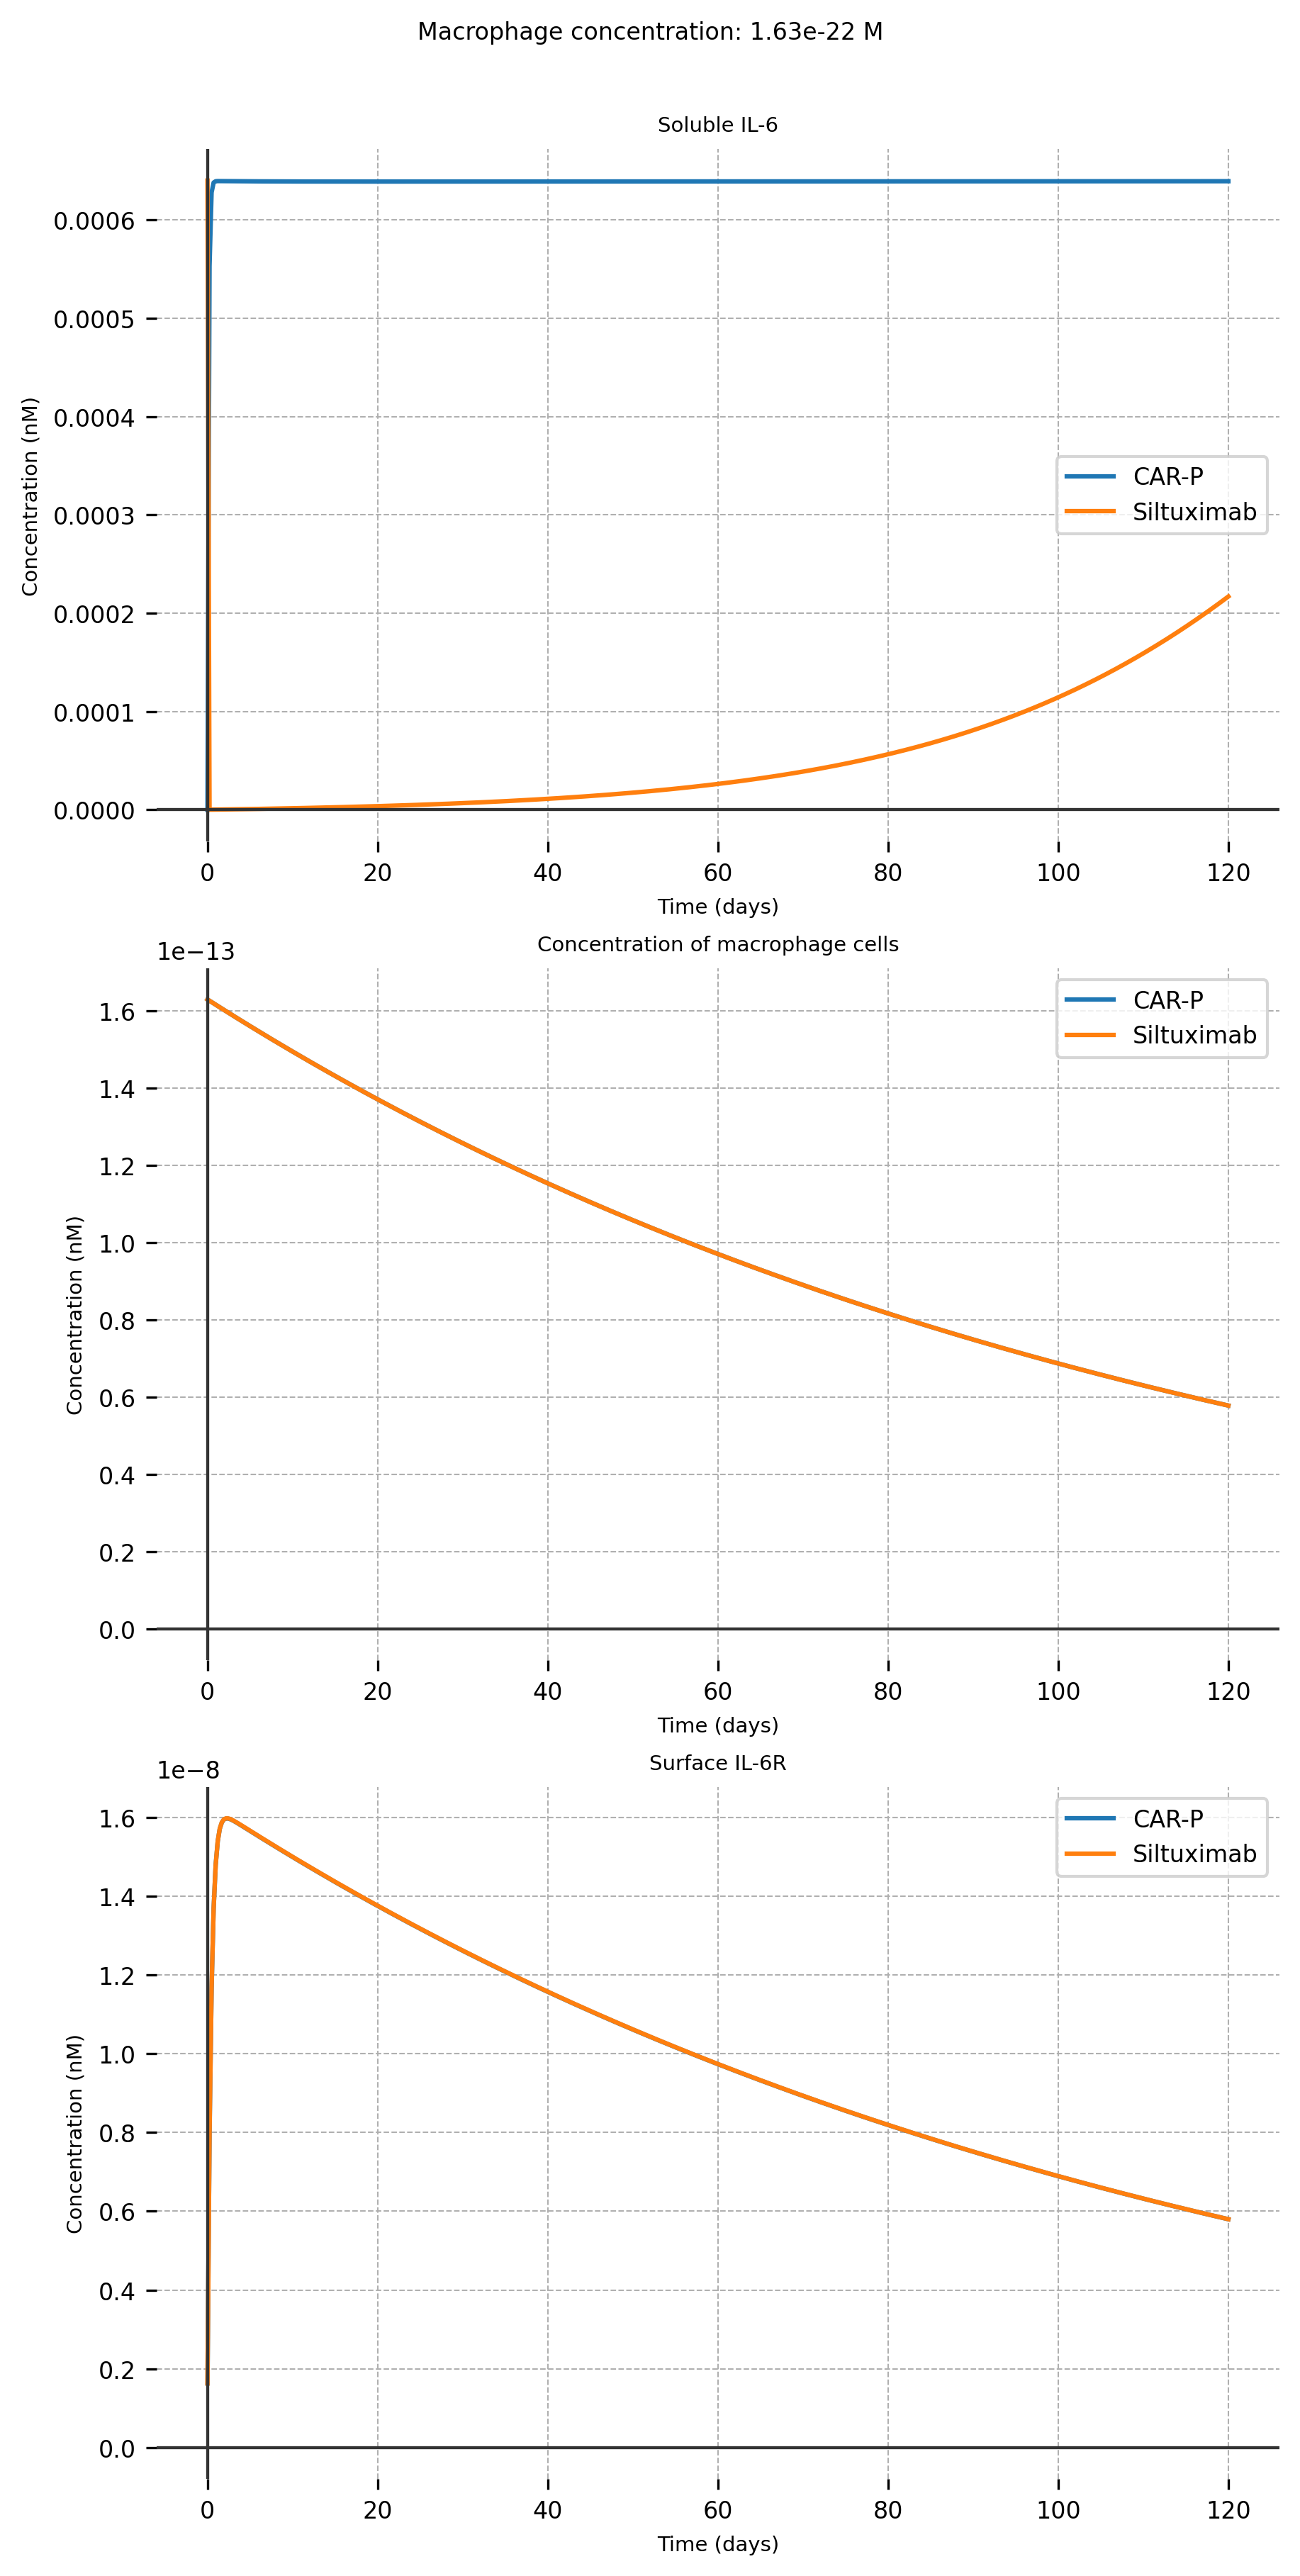

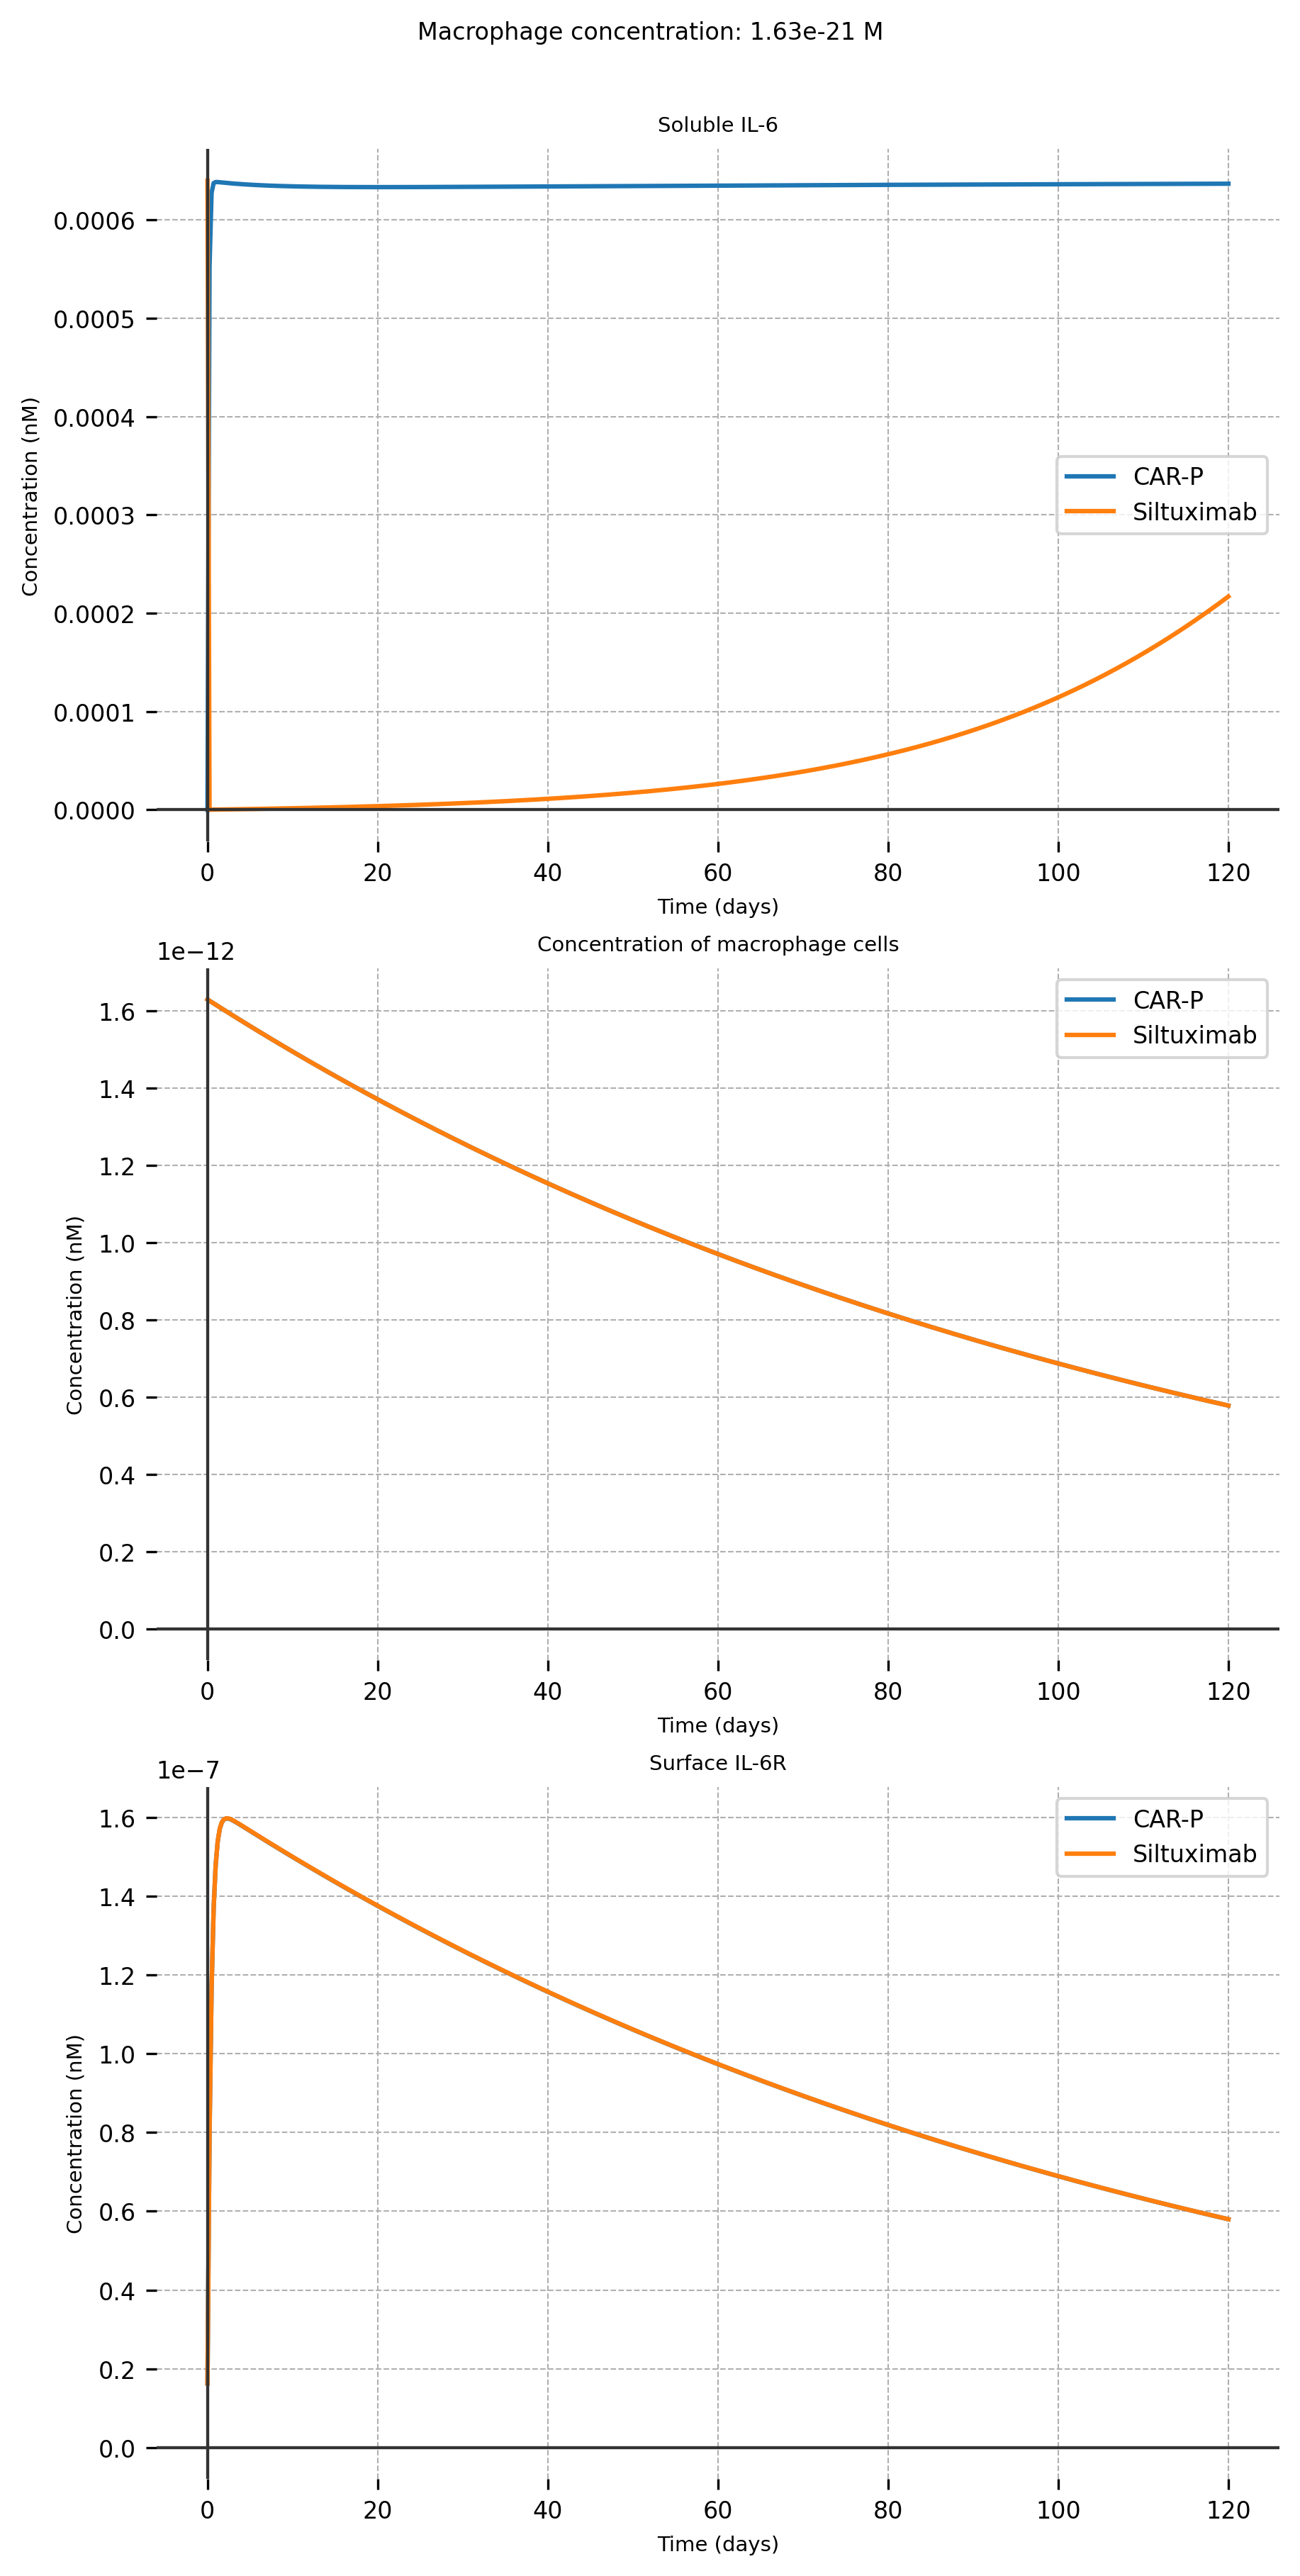

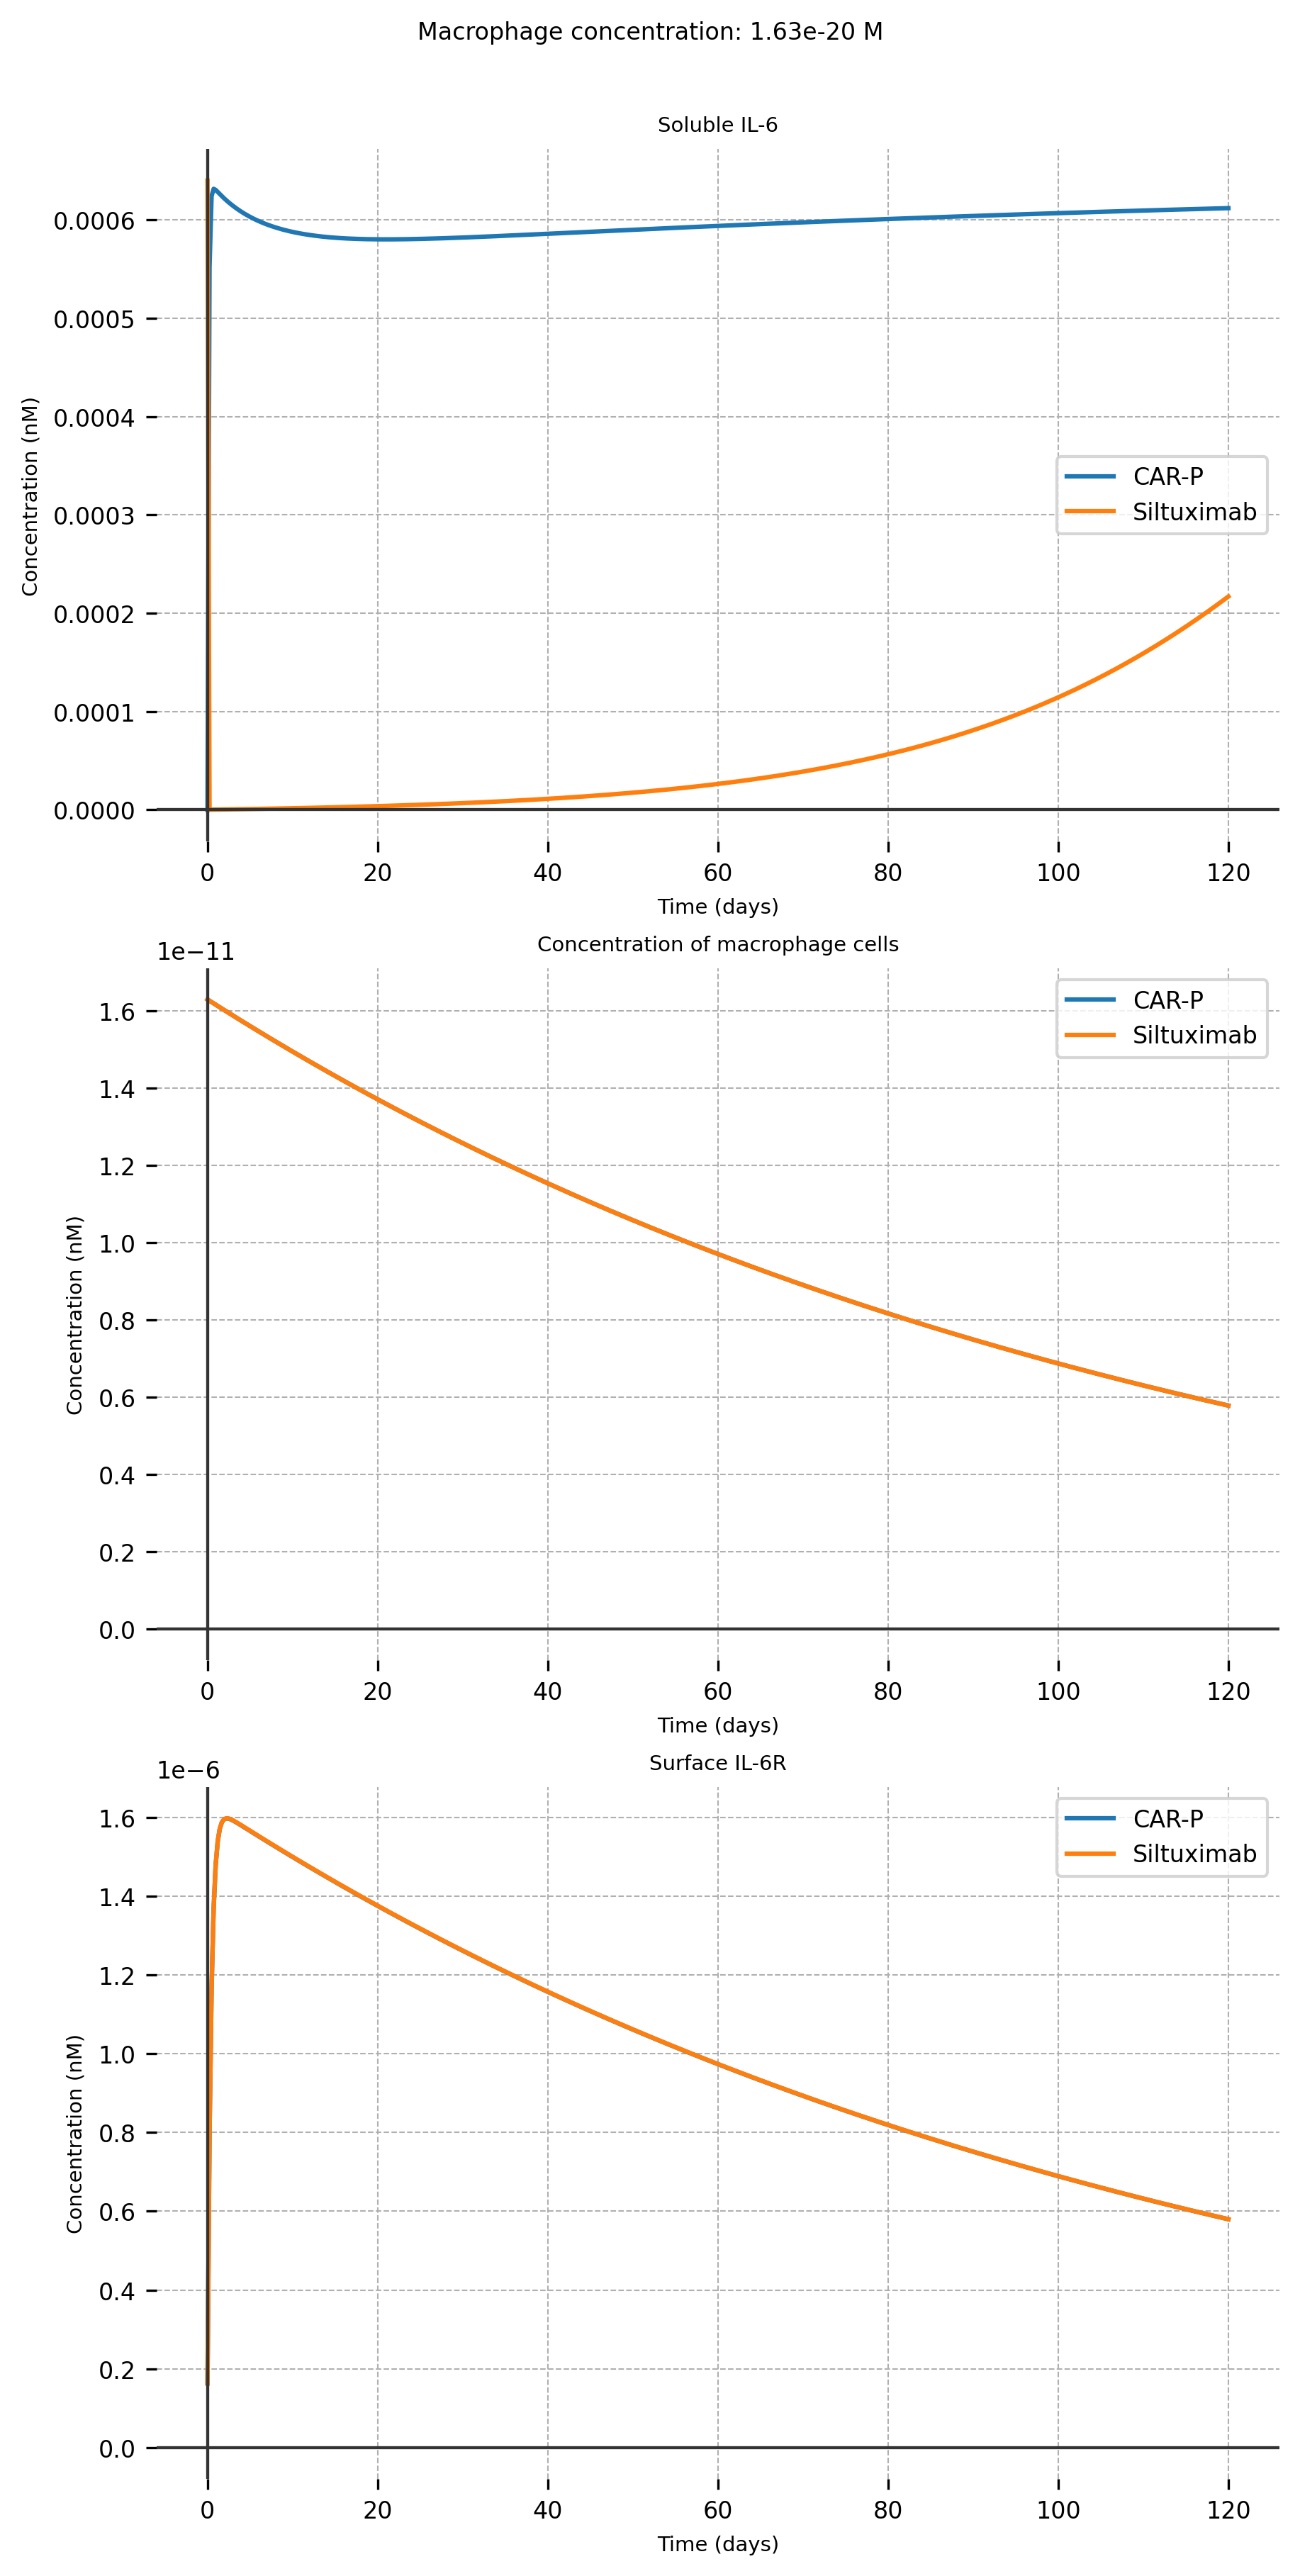

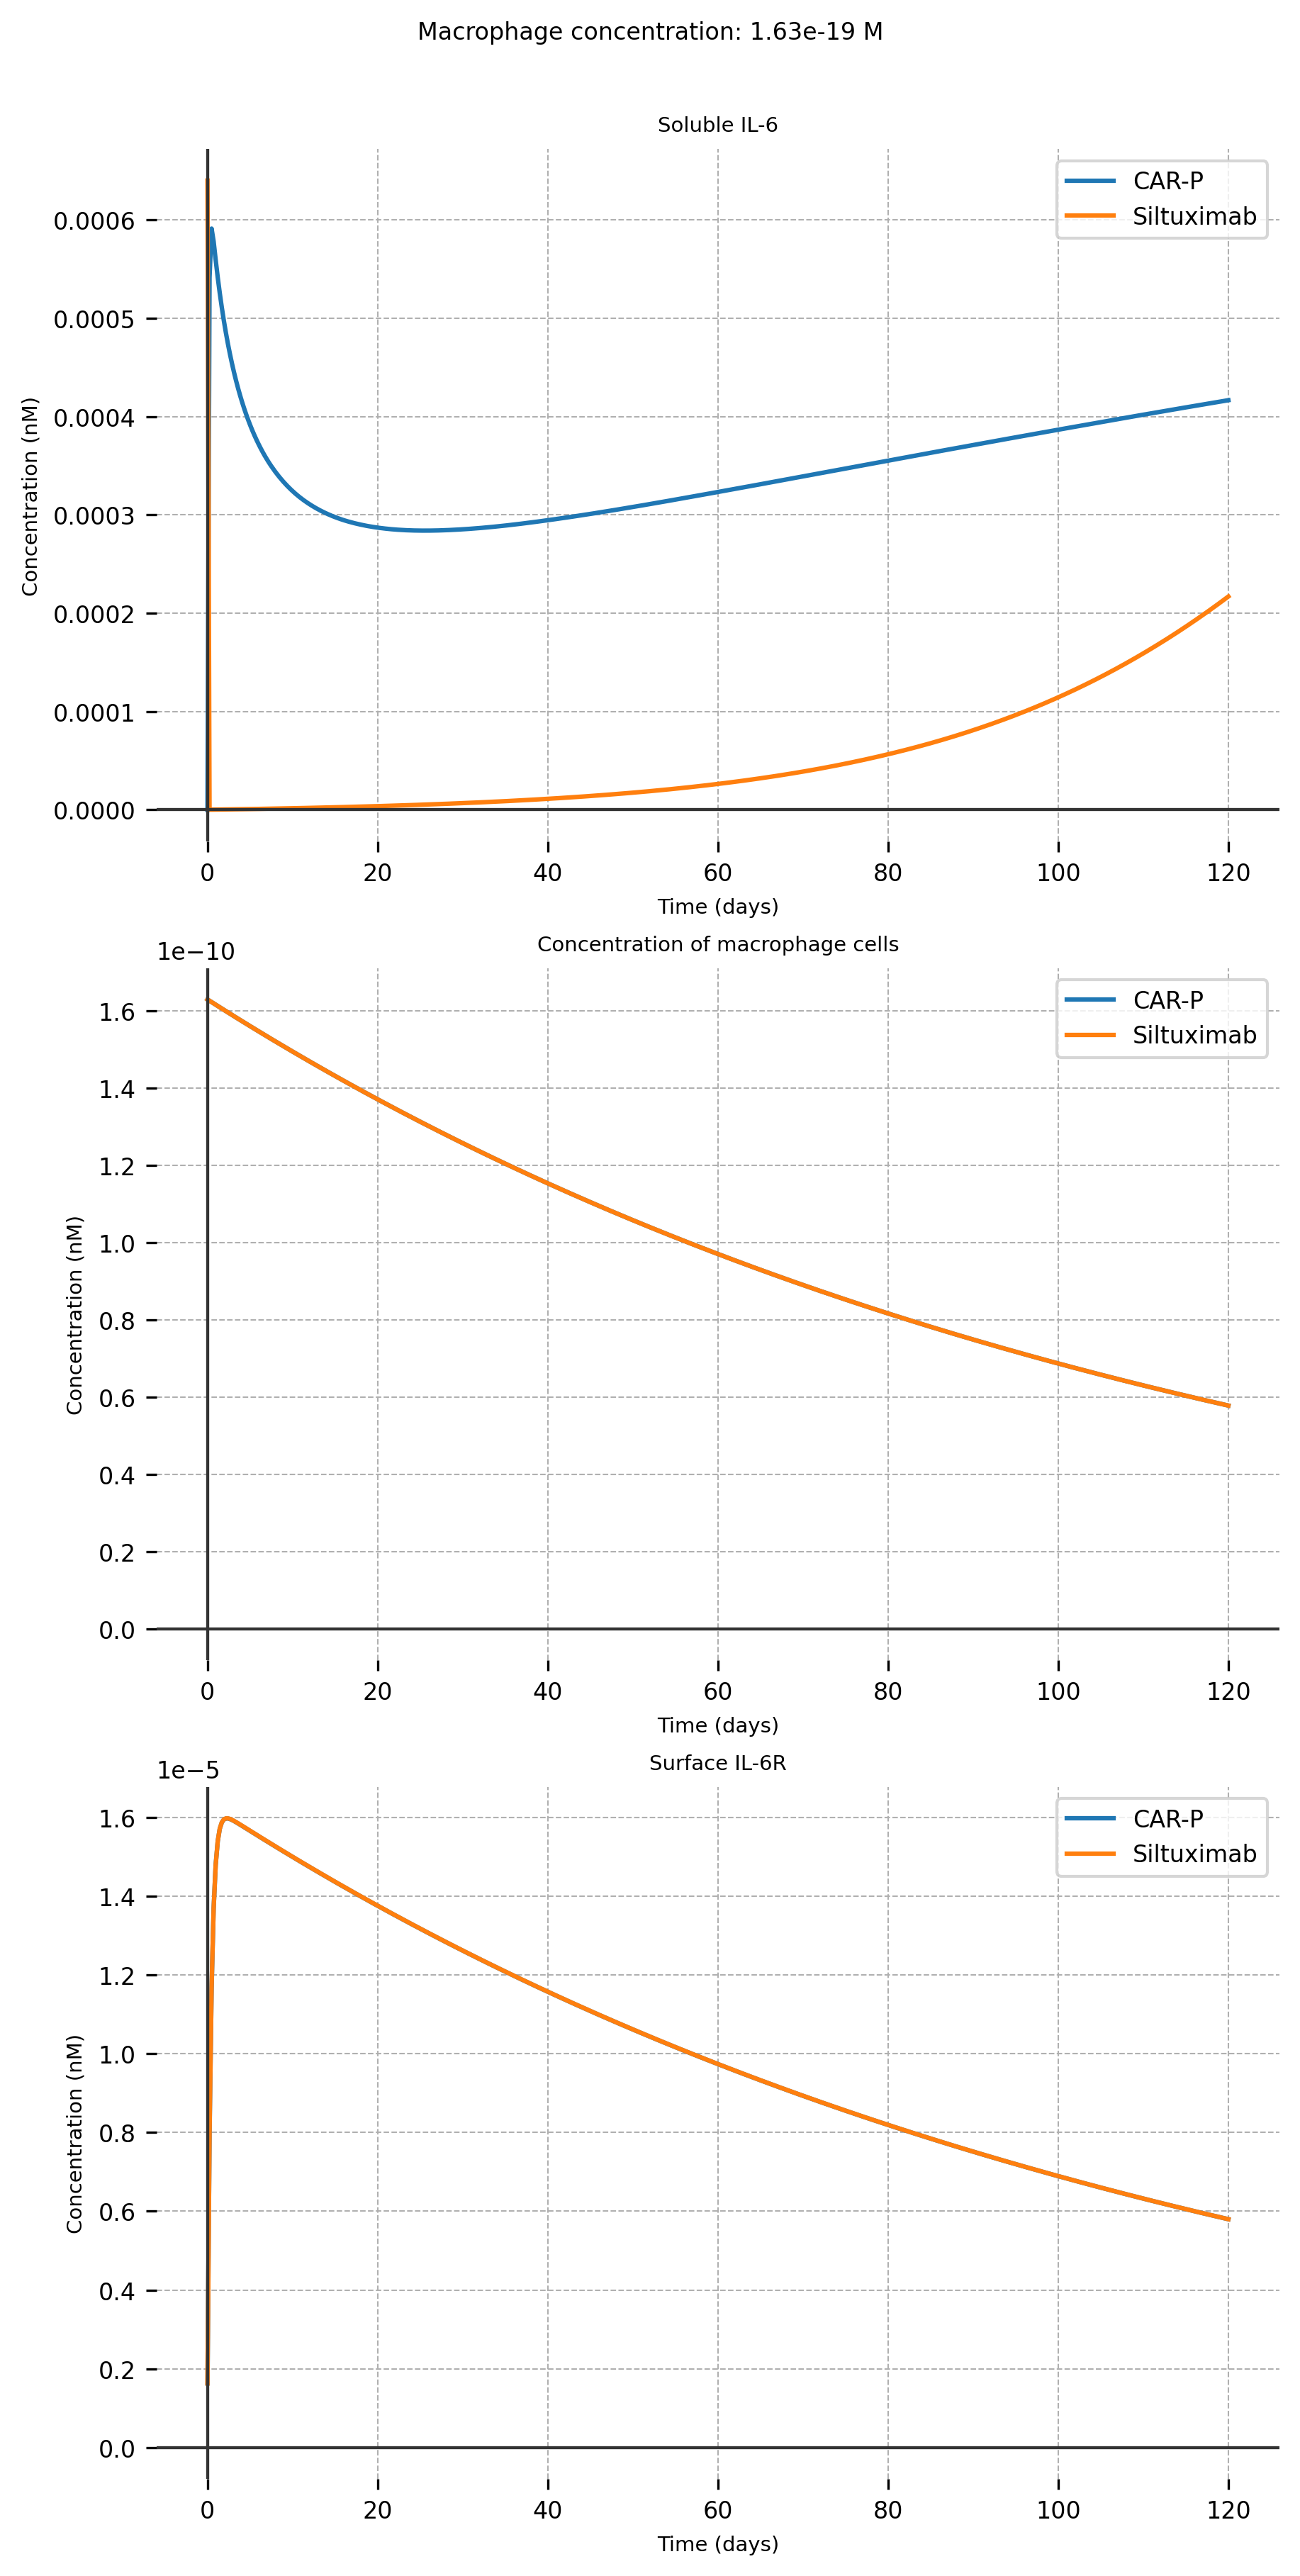

In [35]:
SAVE_FIGS = False   # CHANGE TO FALSE IF YOU WANT TO DISPLAY PLOTS AND NOT DOWNLOAD THEM

# create time axis
simulation_time_mins = 120  # days
t = np.linspace(0, simulation_time_mins*60*60*24, 500)

for macrophage_conc in macrophage_concs:
        constants = rate_constants()
        metadata_CAR, metadata_Ab, combined_metadata = state_variable_metadatas['CAR'](macrophage_conc), \
                                                       state_variable_metadatas['Ab'](macrophage_conc), \
                                                       state_variable_metadatas['combined'](macrophage_conc)

        # Run the simulation
        simulation_results_CAR, solution_CAR = simulate_binding_recycling_and_degradation(t, constants, metadata_CAR, 'CAR')
        simulation_results_Ab, solution_Ab = simulate_binding_recycling_and_degradation(t, constants, metadata_Ab, 'Ab')
        fig, axes = plt.subplots(3, 1, figsize=(6,12), dpi=300, layout="constrained")
        axes = axes.flatten()
        # fig, ax = plt.subplots(figsize=(6,4), dpi=300, layout="constrained")
        fig.suptitle(f'Macrophage concentration: {macrophage_conc} M\n\n',
                        fontsize=8)


        plot_time_axis = simulation_results_CAR['t']/3600/24  # days

        for ax, (key, state_variable) in zip(axes,combined_metadata.items()):
            if key in metadata_Ab.keys() and key in metadata_CAR.keys():
                ax.plot(plot_time_axis, simulation_results_CAR[key]*1e9, label='CAR-P')
                ax.plot(plot_time_axis, simulation_results_Ab[key]*1e9, label='Siltuximab')
                ax.legend()
            elif key in metadata_CAR.keys():
                ax.plot(plot_time_axis, simulation_results_CAR[key]*1e9, label='CAR-P')
            else:
                 ax.plot(plot_time_axis, simulation_results_Ab[key]*1e9, label='Siltuximab')
            set_axes_labels(ax, 'Time (days)', 'Concentration (nM)', state_variable.description, fontsize=7)
            make_plot_look_good(ax)

        if SAVE_FIGS:
            plt.savefig(f'Tumor/macrophage_conc_plots/macrophage_conc_{macrophage_conc}.jpeg', dpi=300)
            plt.close(fig)
        else:
            plt.show()

## single plotting of JUST IL-6 levels

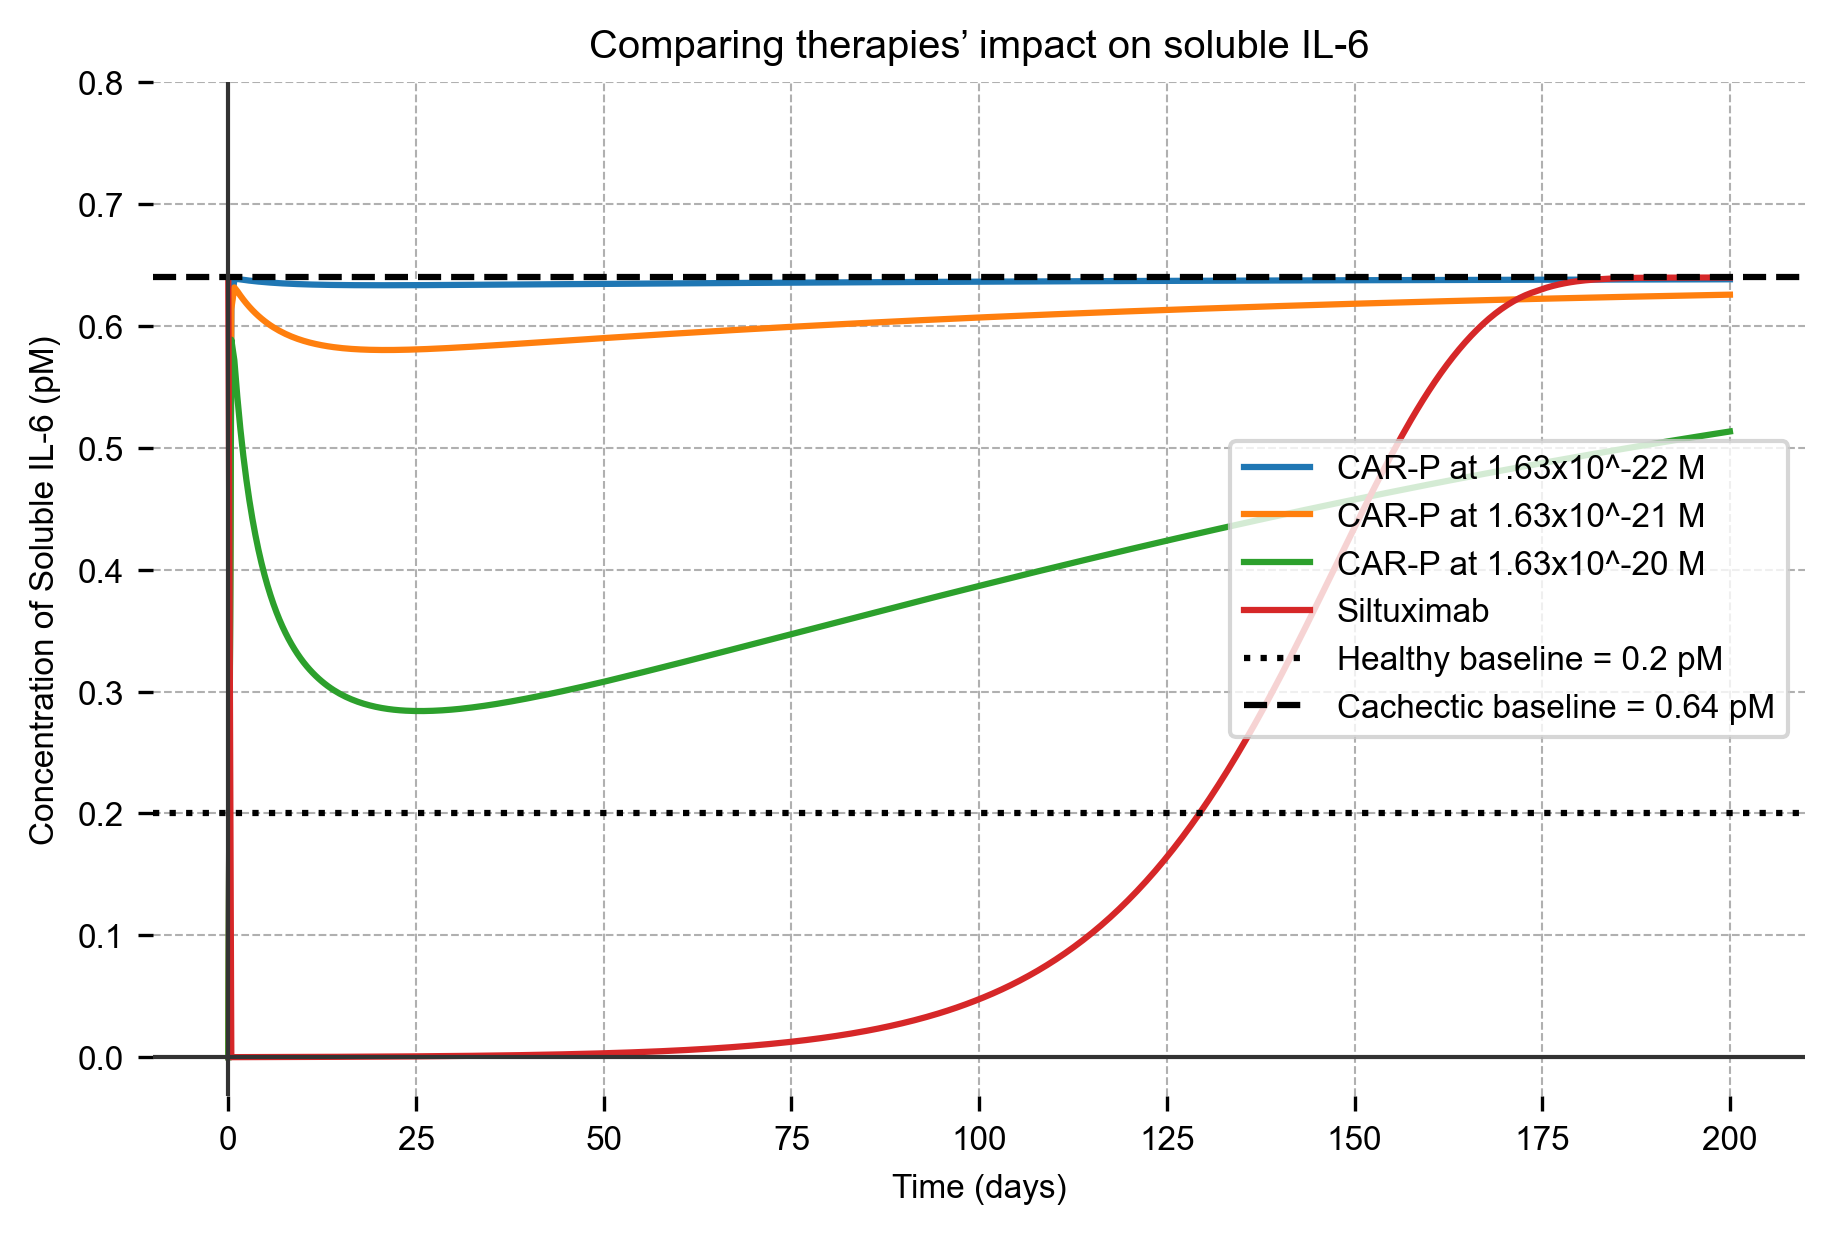

In [95]:
SAVE_FIGS = False   # CHANGE TO FALSE IF YOU WANT TO DISPLAY PLOTS AND NOT DOWNLOAD THEM

# create time axis
simulation_time_mins = 200  # days
t = np.linspace(0, simulation_time_mins*60*60*24, 500)
simulation_results = {}
solutions = {}
fig, ax = plt.subplots(figsize=(6,4), dpi=300, layout="constrained")


for macrophage_conc in macrophage_concs:
    constants = rate_constants()
    metadata_CAR, metadata_Ab, combined_metadata = state_variable_metadatas['CAR'](macrophage_conc), \
                                                    state_variable_metadatas['Ab'](macrophage_conc), \
                                                    state_variable_metadatas['combined'](macrophage_conc)

    # Run the simulation
    simulation_results_CAR, solution_CAR = simulate_binding_recycling_and_degradation(t, constants, metadata_CAR, 'CAR')
    simulation_results_Ab, solution_Ab = simulate_binding_recycling_and_degradation(t, constants, metadata_Ab, 'Ab')

    plot_time_axis = simulation_results_CAR['t']/3600/24  # days

    ax.plot(plot_time_axis, simulation_results_CAR['IL-6']*1e12, label=f'CAR-P at {concentrations[macrophage_conc]} M')

ax.plot(plot_time_axis, simulation_results_Ab['IL-6']*1e12, label='Siltuximab')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Concentration of Soluble IL-6 (pM)')
ax.set_title('Comparing therapies’ impact on soluble IL-6')
plt.ylim(top=0.8)

# Healthy baseline
ax.axhline(y=0.2, color='black', linestyle=':', label='Healthy baseline = 0.2 pM')
# ax.text(0.98, 0.207, 'Healthy baseline', ha='right', va='bottom', transform=ax.get_yaxis_transform(), fontsize=8)

# Cachectic baseline
ax.axhline(y=0.64, color='black', linestyle='--', label='Cachectic baseline = 0.64 pM')
# ax.text(0.98, 0.65, 'Cachectic baseline', ha='right', va='bottom', transform=ax.get_yaxis_transform(), fontsize=8)

ax.legend(loc='right')
make_plot_look_good(ax)

if SAVE_FIGS:
    plt.savefig(f'Tumor/macrophage_conc_plots/macrophage_conc_overlaid.jpeg', dpi=300)
    plt.close(fig)
else:
    plt.show()

## baseline: plotting IL-6R, IL-6 levels, and macrophages levels

In [91]:
SAVE_FIGS = True   # CHANGE TO FALSE IF YOU WANT TO DISPLAY PLOTS AND NOT DOWNLOAD THEM

# create time axis
simulation_time_mins = 10  # days
t = np.linspace(0, simulation_time_mins*60*60*24, 500)

constants = rate_constants()
# Run the simulation
fig, ax = plt.subplots(figsize=(6,4), dpi=300, layout="constrained")

plot_time_axis = simulation_results_CAR['t']/3600/24  # days

for macrophage_conc in macrophage_concs:
    metadata_CAR = state_variable_metadatas['CAR'](macrophage_conc)
    simulation_results_CAR, solution_CAR = simulate_binding_recycling_and_degradation(t, constants, metadata_CAR, 'CAR')

    ax.plot(plot_time_axis, simulation_results_CAR['IL-6']*1e12, label=f'Macrophage concentration: {concentrations[macrophage_conc]} M')

set_axes_labels(ax, 'Time (days)', 'Concentration of soluble IL-6 (pM)', 'Control macrophages lacking CAR-P', fontsize=7)
plt.legend(fontsize=7)
if SAVE_FIGS:
    plt.savefig(f'Tumor/baseline_IL6.jpeg', dpi=300)
    plt.close(fig)
else:
    plt.show()

fig, ax = plt.subplots(figsize=(6,4), dpi=300, layout="constrained")

for macrophage_conc in macrophage_concs:
    metadata_CAR = state_variable_metadatas['CAR'](macrophage_conc)
    simulation_results_CAR, solution_CAR = simulate_binding_recycling_and_degradation(t, constants, metadata_CAR, 'CAR')
    ax.plot(plot_time_axis, simulation_results_CAR['Rs'] / simulation_results_CAR['macrophages'], label=f'Macrophage concentration: {concentrations[macrophage_conc]} M')

set_axes_labels(ax, 'Time (days)', 'Number of IL-6R per macrophage', 'Control macrophages lacking CAR-P', fontsize=7)
plt.legend(fontsize=7)

if SAVE_FIGS:
    plt.savefig(f'Tumor/baseline_IL6R_per_macrophage.jpeg', dpi=300)
    plt.close(fig)
else:
    plt.show()